# Fourier transforms

If a function is defined on the whole real line and not just a single interval (although it may have finite support), it is not necessarily period. It can have sine-like components at all frequencies (wavenumbers), not just those that are interval multiples of $2\pi/L$. The 'coefficients' of such a 'continuous series' are the Fourier transform. 

In general, the Fourier transform of a function is complex even if the function is real. However, if the function is even about $x = 0$ then its FT is real; if it is odd, then its FT is pure imaginary.

Computers can't represent analogue functions exactly. They can only sample them at discrete points. The Fourier transform of a discretely sampled function is called the discrete Fourier transform (DFT). This means that there is a limit to the maximum frequency that can be calculated by the DFT. There is also a limit to the domain width that can be stored, so there is also a minimum frequency of the DFT.

In [164]:
import numpy as np
from scipy.signal import stft, spectrogram, get_window, hamming
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from decorators import CompactSupport, Vectorize

In [236]:
def myfft(ys):
    """Our FT convention that we will use in this course.
    Note that conventions vary between packages and authors
    over the normalisation.
    For this course, we want our FTs to be independent of
    the sample rate, so we'll normalise by multiplying by 2/nx.
    """
    # TODO - sort out the normalisation. It's wrong.
    return np.fft.fftshift(np.fft.fft(ys, norm="ortho")) # * 2 / (np.pi * len(ys))

def myifft(yfts):
    return np.fft.ifft(np.fft.ifftshift(yfts), norm="ortho")

In [3]:
# The domain
def get_domain(nx, xmax):
    xs = np.linspace(-xmax, xmax, nx+1)[:-1]
    dx = xs[1] - xs[0]
    nyquist = np.pi / dx
    ks = np.linspace(-nyquist, nyquist, nx+1)[:-1]
    dk = ks[1] - ks[0]
    return [xs, dx, ks, dk]

## Question 7: FTs of functions of finite extent

In [239]:

@interact(c=widgets.FloatSlider(min=0, max=3, value=0.4, continuous_update=False),
          a=widgets.FloatSlider(min=0, max=10, value=1, continuous_update=False),
          fn=["tophat", "sinax", "cosax"])
def q7demo(c, a, fn):
    @Vectorize
    @CompactSupport(-c, c)
    def tophat(x):
        return 1
    
    @Vectorize
    @CompactSupport(-c, c)
    def sinax(x):
        return np.sin(a*x)
    
    @Vectorize
    @CompactSupport(-c, c)
    def cosax(x):
        return np.cos(a*x)
    
    xs, dx, ks, dk = get_domain(1024, xmax=24)
    ys = locals()[fn](xs)
    yfts = myfft(ys)
#     print(np.sum(np.real(yfts)) * dk)
#     print(np.sum(np.abs(ys)**2) * dx, np.sum(np.abs(yfts) ** 2 * dk))
    fig, axs = plt.subplots(1, 2, figsize=[14, 5])
    axs[0].plot(xs, ys, 'k-')
    axs[0].set(xlim=[-4,4])
    axs[1].plot(ks, np.real(yfts), 'r-',
                ks, np.imag(yfts), 'b-')
    axs[1].set(xlim=[-15,15])
    plt.show()

interactive(children=(FloatSlider(value=0.4, continuous_update=False, description='c', max=3.0), FloatSlider(v…

## Question 9: FTs of Gaussians

In [241]:
@interact(n=widgets.FloatSlider(min=0, max=8, value=1, continuous_update=False),
          m=widgets.FloatSlider(min=-5, max=5, value=0, continuous_update=False))
def q8demo(n, m):
    @Vectorize
    def gaussian(x):
        return np.exp(-n**2 * (x - m)**2)
    
    xs, dx, ks, dk = get_domain(nx=1024, xmax=32)
    ys = gaussian(xs)
    yfts = myfft(ys)
#     print(np.sum(np.real(yfts)) * dk)
#     print(np.sum(np.abs(ys)**2) * dx, np.sum(np.abs(yfts) ** 2 * dk))
    fig, axs = plt.subplots(2, 2, figsize=[14, 8])
    axs[0, 0].plot(xs, ys, 'k-')
    axs[0, 0].set(xlim=[-10,10], ylim=[-.1, 1.1])
    axs[0, 0].grid()

    axs[0, 1].plot(ks, np.abs(yfts), 'k-')
    axs[0, 1].set(title="Magnitude of FT", xlim=[-15,15])
    axs[0, 1].grid()

    axs[1, 0].plot(ks, np.real(yfts), 'r-',
                   ks, np.abs(yfts), 'k--',
                   ks, -np.abs(yfts), 'k--')
    axs[1, 0].set(title="Real part of FT", xlim=[-15,15])
    axs[1, 0].grid()
    axs[1, 1].plot(ks, np.imag(yfts), 'b-',
                   ks, np.abs(yfts), 'k--',
                   ks, -np.abs(yfts), 'k--')
    axs[1, 1].set(title="Imaginary part of FT", xlim=[-15,15])
    axs[1, 1].grid()

    plt.show()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='n', max=8.0), FloatSlider(v…

## Bonus: Transfer functions

Since the Fourier modes $\exp(\mathrm{i} k x)$ are the eigenfunctions of the differential operator (that don't blow up as $x \rightarrow \pm\infty$, many inhomogeneous linear differential equations 
$$ (Ly)(x) = f(x) $$
can be solved by looking at their behaviour on individual Fourier modes. 

If $L$ is a linear differential operator with constant coefficients, transforming the differential equation gives something like
$$
K(k) \hat(y)(k) = \hat{f}(k), 
$$
and the solution is given by inverse-transforming $\hat{f}(k) / K(k)$. The function $K(k)$ is called the transfer function as it tells you the response of $L$ to each mode.

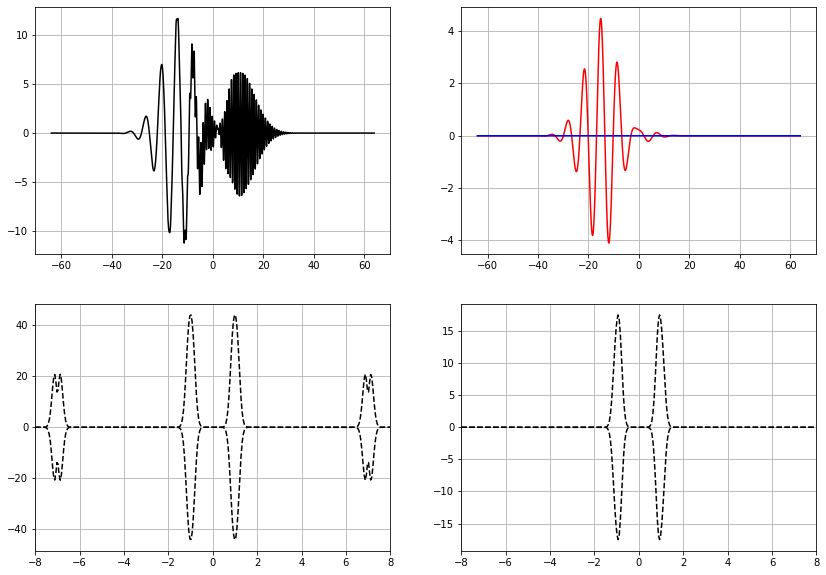

In [104]:
@np.vectorize
def transfer_function(k):
    return np.exp(-k**2) * np.exp(1j * k)

xs, dx, ks, dk = get_domain(nx=4096, xmax=64)
ys = (xs-2) * np.exp(-(xs-5)**2 / 100) * np.sin(7*xs) + (xs) * np.exp(-(xs+10)**2 / 100) * np.sin(xs)
yfts = myfft(ys)
y_out_fts = transfer_function(ks) * yfts 
y_outs = myifft(y_out_fts)
fig, axs = plt.subplots(2, 2, figsize=[14, 10])
axs[0,0].plot(xs, ys, 'k-')
axs[0,0].grid()
axs[0,1].plot(xs, np.real(y_outs), 'r-',
            xs, np.imag(y_outs), 'b-')
axs[0,1].grid()

axs[1,0].plot(#ks, np.real(yfts), 'r-',
              #ks, np.imag(yfts), 'b-',
              ks, np.abs(yfts), 'k--',
              ks, -np.abs(yfts), 'k--')
axs[1,0].set(xlim=[-8, 8])
axs[1,0].grid()

axs[1,1].plot(#ks, np.real(y_out_fts), 'r-',
              #ks, np.imag(y_out_fts), 'b-',
              ks, np.abs(y_out_fts), 'k--',
              ks, -np.abs(y_out_fts), 'k--')
axs[1,1].set(xlim=[-8, 8])
axs[1,1].grid()

## Bonus: Short-time Fourier transform (STFT) and spectrogram

Signals that modulate over time can be represented using a spectrogram, which shows the 'local' Fourier transform in a window around the local time (_i.e._ the convolution of the function with the window). 

As the following demo shows, the window size can be adjusted to change the precision of the spectrogram in the time and frequency domains. A narrower window improves precision in the time domain but reduces precision in the frequency domain, while a wider window does the opposite. This is the same behaviour as the uncertainty principle in quantum mechanics, where a particle's momentum is proportional to the wavenumber of its wavefunction: a precise measurement of location reduces the precision to which momentum can be measured.

In [237]:
@interact(window_width=widgets.IntSlider(min=2, max=500, value=200,
                                         continuous_update=False))
def stftdemo(window_width):
    xmax = 24
    xs, dx, ks, dk = get_domain(nx=12000, xmax=xmax)
    ys = np.array([np.sin((30 + np.exp(x / 3))*x) * np.exp(-x**2 / 50) 
                   + (0.5 * np.sin(60*x) if -8 < x < -2 else 0)
                   for x in xs])

    f, t, Zxx = stft(ys, fs=1/dx,
                     nperseg=window_width,
                     window=hamming(window_width))
    
    fig, axs = plt.subplots(2, 1, figsize=[14,8])
    axs[0].plot(xs, ys)
    axs[0].set(xlim=[-20, 20])
    plt.pcolormesh(t-xmax, f*2*np.pi, np.abs(Zxx))
    plt.gca().set(xlim=[-20, 20], ylim=[0, 100])

interactive(children=(IntSlider(value=200, continuous_update=False, description='window_width', max=500, min=2…